In [1]:
import numpy as np
from graph_cert.certify import *
from graph_cert.utils import *
from graph_cert.models import PiPPNP
from graph_cert.training import *
from functools import partial

import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

### Load and preprocess the data

In [2]:
file_name = 'data/citeseer.npz'
graph = load_dataset(file_name=file_name)

adj_matrix, attr_matrix, labels = standardize(adj_matrix=graph['adj_matrix'],
                                              attr_matrix=graph['attr_matrix'],
                                              labels=graph['labels'])

idx_train, idx_val, idx_test = split(labels, n_per_class=20, seed=0)

### Setup the training function with default hyper-params


In [3]:
device = 'cuda'
alpha = 0.85
n, d = attr_matrix.shape
nc = labels.max()+1

attr = torch.FloatTensor(attr_matrix.toarray()).to(device)
ppr = torch.FloatTensor(propagation_matrix(adj_matrix, alpha=alpha)).to(device)
labels = torch.LongTensor(labels).to(device)

In [4]:
train_func = partial(train, attr=attr, ppr=ppr, labels=labels,
                     idx_train=idx_train, idx_val=idx_val,
                     lr=1e-2, weight_decay= 1e-4,
                     patience=10, max_epochs=10_000, display_step=5,
                    )

### Train $\pi$-PPNP using standard cross-entropy loss

In [5]:
ppnp_ce = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_ce, adver_config=None)

Epoch    0: loss_train: 1.79467, loss_val: 1.79423  acc_train: 0.16667, acc_val: 0.16667 p_robust -1.00000
Epoch    5: loss_train: 0.55747, loss_val: 1.00037  acc_train: 0.89167, acc_val: 0.69167 p_robust -1.00000
Epoch   10: loss_train: 0.12188, loss_val: 1.08551  acc_train: 0.98333, acc_val: 0.67500 p_robust -1.00000
Epoch   15: loss_train: 0.03441, loss_val: 1.49981  acc_train: 1.00000, acc_val: 0.68333 p_robust -1.00000
Epoch   20: loss_train: 0.01191, loss_val: 1.85369  acc_train: 1.00000, acc_val: 0.65000 p_robust -1.00000


### Configure the paramters for adversarial training

In [6]:
# set the local budget proportional to the degree
deg = adj_matrix.sum(1).A1.astype(np.int32)
local_strength = 9
local_budget = np.maximum(deg - 11 + local_strength, 0)

fragile = get_fragile(adj=adj_matrix, threat_model='rem')

adver_config = {
    'alpha': alpha,
    'adj_matrix': adj_matrix,
    'fragile': fragile,
    'local_budget': local_budget,
    'margin': 0
}

### Train $\pi$-PPNP using robust cross-entropy loss

In [7]:
adver_config['loss_type'] = 'rce'
ppnp_rce = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_rce, adver_config=adver_config)

Epoch    0: loss_train: 1.79794, loss_val: 1.79710  acc_train: 0.16667, acc_val: 0.16667 p_robust 0.16667
Epoch    5: loss_train: 0.71631, loss_val: 1.17327  acc_train: 0.88333, acc_val: 0.67500 p_robust 0.74583
Epoch   10: loss_train: 0.22392, loss_val: 1.39474  acc_train: 0.96667, acc_val: 0.66667 p_robust 0.76667
Epoch   15: loss_train: 0.09586, loss_val: 2.04099  acc_train: 0.98333, acc_val: 0.61667 p_robust 0.76667


### Train $\pi$-PPNP using robust hinge loss

In [8]:
adver_config['loss_type'] = 'cem'
ppnp_cem = PiPPNP(n_features=d, n_classes=nc, n_hidden=[64]).to(device)
_ = train_func(model=ppnp_cem, adver_config=adver_config)

Epoch    0: loss_train: 2.08335, loss_val: 2.08411  acc_train: 0.16667, acc_val: 0.16667 p_robust 0.16667
Epoch    5: loss_train: 1.37598, loss_val: 1.71822  acc_train: 0.86667, acc_val: 0.63333 p_robust 0.70000
Epoch   10: loss_train: 0.73256, loss_val: 1.67382  acc_train: 0.92500, acc_val: 0.66667 p_robust 0.70833
Epoch   15: loss_train: 0.30869, loss_val: 2.15397  acc_train: 0.97500, acc_val: 0.65000 p_robust 0.76667
Epoch   20: loss_train: 0.13383, loss_val: 2.85887  acc_train: 0.99167, acc_val: 0.64167 p_robust 0.76250


### Compute the ratios of certified test nodes

In [9]:
local_strengths = [1, 3, 5, 7, 9]
ratios_certifed = np.zeros((3, len(local_strengths)))

for it, model in enumerate(tqdm.tqdm_notebook([ppnp_ce, ppnp_cem, ppnp_rce])):
    
    logits, weighted_logits = model(attr, ppr)
    acc_test = accuracy(labels, weighted_logits, idx_test)
    print(f'Accuracy: {acc_test:.5f}')
    
    logits = logits.detach().cpu().numpy()
    predicted = weighted_logits.argmax(1).cpu().numpy()

    for jt, local_strength in enumerate(tqdm.tqdm_notebook(local_strengths, leave=False)):
        # set the local budget proportional to the node degree
        local_budget = np.maximum(deg - 11 + local_strength, 0)

        # precomputed the K x K perturbed graphs
        k_squared_pageranks = k_squared_parallel(
        adj=adj_matrix, alpha=alpha, fragile=fragile, local_budget=local_budget, logits=logits, nodes=idx_test)

        # compute the exact worst-case margins for all test nodes
        worst_margins = worst_margins_given_k_squared(
            k_squared_pageranks=k_squared_pageranks, labels=predicted[idx_test], logits=logits)

        ratios_certifed[it, jt] = (worst_margins>0).mean()

Accuracy: 0.67968


Accuracy: 0.68342


Accuracy: 0.68503


### Compare different losses

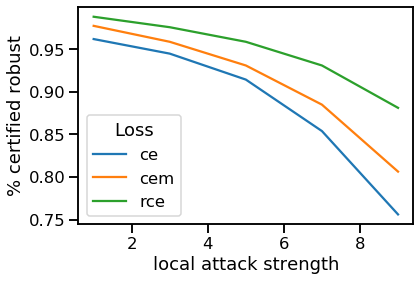

In [10]:
sns.set_context('talk')
plt.plot(local_strengths, ratios_certifed[0], label='ce')
plt.plot(local_strengths, ratios_certifed[1], label='cem')
plt.plot(local_strengths, ratios_certifed[2], label='rce')
plt.xlabel('local attack strength')
plt.ylabel('% certified robust')
plt.legend(title='Loss')
plt.show()